In [9]:
# https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision import models
import os

In [10]:
def count_target_classes(root_dir):
    '''return count of number of images per class'''
    target_classes = {}
    for folder in sorted(os.listdir(root_dir)):
        data_path_for_image_folder = root_dir+ '/'+str(folder) + '/'
        target_classes[str(folder)] = len([image_filename for image_filename in sorted(os.listdir(data_path_for_image_folder))])
    return target_classes

def dataset_loader(path, val_split, test_split, input_size, batch_size, shuffle_test=False):
    
    transform_dict = {'src':  transforms.Compose([transforms.Resize(input_size), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomAdjustSharpness(0.2),
                                                transforms.RandomAutocontrast(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])}

    data = datasets.ImageFolder(root=path, transform=transform_dict["src"])

    test_size = int(len(data) * test_split)
    train_size_temp = len(data)- test_size

    train_dataset_temp, test_dataset = td.random_split(data, [train_size_temp, test_size])

    val_size = int(len(train_dataset_temp) * val_split)
    train_size = len(train_dataset_temp) - val_size

    # split validate set from train set: https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio
    train_dataset, val_dataset = td.random_split(train_dataset_temp, [train_size, val_size])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)

    return train_loader, val_loader, test_loader

In [11]:
root_ds_path = "C:/Users/Damian/Documents/School/Fall 2022 - Grad School/Comp 6721/Project/Repo"
root_txt_path = "C:/Users/Damian/Documents/School/Fall 2022 - Grad School/Comp 6721/Project/Repo/My Work/Model_Stats"
root_model_path = "C:/Users/Damian/Documents/School/Fall 2022 - Grad School/Comp 6721/Project/Repo/My Work/Saved_Models/"
root_saved_model_path = "C:/Users/Damian/Documents/School/Fall 2022 - Grad School/Comp 6721/Project/Repo/Damians Stuff/Saved_Models/"

ds_dir_dict = {"EuroSat": root_ds_path+"/LandscapeClassification/Datasets/EuroSat/EuroSAT", 
               "Landuse": root_ds_path+"/LandscapeClassification/Datasets/Land-Use Scene Classification/images",
               "SRSI": root_ds_path+"/LandscapeClassification/Datasets/SRSI RSI CB256/data"}

model_dict = {"VGG": [models.vgg16(weights=None), 4096],
              "ResNet": [models.resnet50(weights=None), 2048],
              "EffNet": [models.efficientnet_b0(weights=None), 2048]}

In [12]:
dict_class_count = {}
for ds in ds_dir_dict:
    data_dir = ds_dir_dict[ds]
    dict_class_count[ds] = count_target_classes(data_dir)
    train_loader, val_loader, test_loader = dataset_loader(data_dir, val_split=.2, test_split=0.2, input_size=[64,64], batch_size=32)

In [53]:
# https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/
data = datasets.ImageFolder(root=root_ds_path+"/LandscapeClassification/Datasets/EuroSat/EuroSAT")

X = []
Y = []
for x,y in data:
    X.append(np.array(x).reshape(64*64*3))
    Y.append(y)
arrX = np.array(X)
arrY = np.array(Y)

# Randomly select 1000 samples for performance reasons
np.random.seed(100)
subsample_idc = np.random.choice(arrX.shape[0], 1000, replace=False)
X = arrX[subsample_idc,:]
y = arrY[subsample_idc]

# Show two example images
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(arrX[11], 'Greys')
# ax[1].imshow(arrX[15], 'Greys')
# ax[0].set_title(arrY[11])
# ax[1].set_title(arrY[15])

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


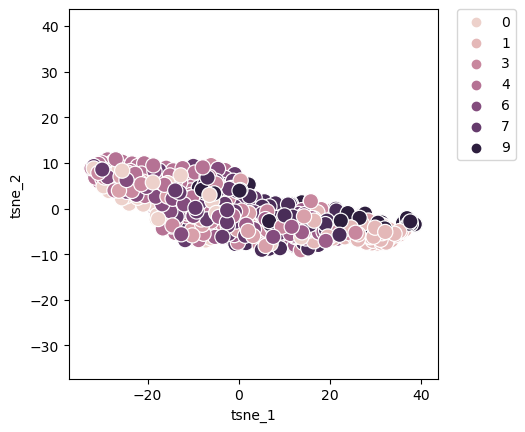

In [55]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)